# GoogLeNet (2014)

[Going Deeper with Convolutions](https://arxiv.org/pdf/1409.4842.pdf)

- Author: Christian Szegedy et al. (Google Inc.)

## imports

In [1]:
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import concatenate, Input, Conv2D, MaxPooling2D, Dropout, Flatten, add
from tensorflow.keras.layers import AveragePooling2D, BatchNormalization, Dense, Activation 
from tensorflow.keras.models import Model

In [2]:
Image(url='https://gaussian37.github.io/assets/img/dl/concept/inception/0.png')

## Prepare Datasets

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
x_train.shape, y_train.shape

((50000, 32, 32, 3), (50000, 1))

In [5]:
x_test.shape, y_test.shape

((10000, 32, 32, 3), (10000, 1))

image normalization

In [6]:
x_train = x_train / 255
x_test = x_test / 255

Hyperparameter

In [7]:
IMAGE_W = 32
IMAGE_H = 32
IMAGE_C = 3
BATCH_SIZE = 32
NUM_CLASSES = 10

## Model

## Inception Module

In [8]:
Image(url='https://cdn.analyticsvidhya.com/wp-content/uploads/2018/10/Screenshot-from-2018-10-17-11-14-10.png', width=650)

In [9]:
def inception(x, filters): 
    # 1x1, 3x3, 5x5, common 1x1
    f1, f2, f3, f4 = filters

    # 1x1
    conv1 = Conv2D(f1, kernel_size=(1,1), padding='same', activation='relu')(x)
    
    # 1x1 & 3x3
    conv2 = Conv2D(f4, kernel_size=(1,1), padding='same', activation='relu')(x)
    conv2 = Conv2D(f2, kernel_size=(3,3), padding='same', activation='relu')(conv2)

    # 1x1 & 5x5
    conv3 = Conv2D(f4, kernel_size=(1,1), padding='same', activation='relu')(x)
    conv3 = Conv2D(f3, kernel_size=(5,5), padding='same', activation='relu')(conv3)
    
    # pooling & 1x1
    maxpool = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(x)
    maxpool = Conv2D(f4, kernel_size=(1,1), padding='same')(maxpool)

    # concatenate 시 (batch, w, h, c) 참고
    output_ = concatenate([conv1, conv2, conv3, maxpool], axis=-1)
    return output_

In [10]:
Image(url='https://media.geeksforgeeks.org/wp-content/uploads/20200429201421/Inception-layer-by-layer.PNG')

In [11]:
IMAGE_W = 32
IMAGE_H = 32

In [12]:
input_shape = (IMAGE_W, IMAGE_H, IMAGE_C)   
inputs = Input(shape=input_shape)

# conv
x = Conv2D(64, kernel_size=(7, 7), strides=2, padding='same', activation='relu')(inputs)

# maxpool
# x = MaxPooling2D(2, 2)(x)

# normalization
x = BatchNormalization()(x)

# conv
x = Conv2D(192, kernel_size=(3, 3), strides=1, padding='same', activation='relu')(x)

# maxpool
# x = MaxPooling2D(2, 2)(x)

# normalization
x = BatchNormalization()(x)

# inception 3a
# 64, 128, 32, 32
x = inception(x,[64, 128, 32, 32])

# inception 3b
# 128, 192, 96, 64
x = inception(x,[128, 192, 96, 64])

# maxpool
x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

# inception 4a
# 192, 208, 48, 64
x = inception(x,[192, 208, 48, 64])

# aux1
aux1 = Flatten()(x)
aux1 = Dense(512, activation='relu')(aux1)
aux1 = Dense(NUM_CLASSES, activation='softmax', name='aux1')(aux1)

# inception 4b
# 160, 224, 64, 64
x = inception(x,[160, 224, 64, 64])

# inception 4c
# 128, 256, 64, 64
x = inception(x,[128, 256, 64, 64])

# inception 4d
# 112, 288, 64, 64
x = inception(x,[112, 288, 64, 64])

# aux2
aux2 = Flatten()(x)
aux2 = Dense(832, activation='relu')(aux2)
aux2 = Dense(NUM_CLASSES, activation='softmax', name='aux2')(aux2)

# inception 4e
# 256, 320, 128, 128
x = inception(x,[256, 320, 128, 128])

# maxpool
# x = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(x)

# inception 5a
# 256, 320, 128, 128
x = inception(x,[256, 320, 128, 128])

# inception 5b
# 384, 384, 128, 128
x = inception(x,[384, 384, 128, 128])

# average pooling
x = AveragePooling2D(pool_size=(4, 4), padding='valid')(x)

# flatten
x = Flatten()(x)

# dropout
x = Dropout(0.4)(x)

# FC
x = Dense(1000)(x)

output_ = Dense(NUM_CLASSES, activation='softmax', name='output')(x)

model = Model(inputs=inputs, outputs=[aux1, aux2, output_])

In [13]:
Image(url='https://media.geeksforgeeks.org/wp-content/uploads/20200429201421/Inception-layer-by-layer.PNG')

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 16, 16, 64)   256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 192)  110784      batch_normalization[0][0]        
______________________________________________________________________________________________

In [15]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

## fit()

In [16]:
EPOCHS = 10

In [17]:
history = model.fit(x_train, y_train, 
                    validation_data=(x_test, y_test), 
                    epochs=EPOCHS
                   )

Epoch 1/10
1563/1563 [==============================] - 47s 27ms/step - loss: 5.8205 - aux1_loss: 2.0387 - aux2_loss: 1.8961 - output_loss: 1.8857 - aux1_acc: 0.4102 - aux2_acc: 0.3713 - output_acc: 0.3218 - val_loss: 4.3484 - val_aux1_loss: 1.2973 - val_aux2_loss: 1.4177 - val_output_loss: 1.6334 - val_aux1_acc: 0.5476 - val_aux2_acc: 0.5169 - val_output_acc: 0.4376
Epoch 2/10
1563/1563 [==============================] - 42s 27ms/step - loss: 3.3632 - aux1_loss: 1.0022 - aux2_loss: 1.1074 - output_loss: 1.2536 - aux1_acc: 0.6438 - aux2_acc: 0.6064 - output_acc: 0.5483 - val_loss: 2.9658 - val_aux1_loss: 0.9143 - val_aux2_loss: 0.9802 - val_output_loss: 1.0713 - val_aux1_acc: 0.6763 - val_aux2_acc: 0.6518 - val_output_acc: 0.6105
Epoch 3/10
1563/1563 [==============================] - 42s 27ms/step - loss: 2.6361 - aux1_loss: 0.7788 - aux2_loss: 0.8649 - output_loss: 0.9924 - aux1_acc: 0.7315 - aux2_acc: 0.6980 - output_acc: 0.6540 - val_loss: 3.0027 - val_aux1_loss: 0.9207 - val_aux2_

## 시각화

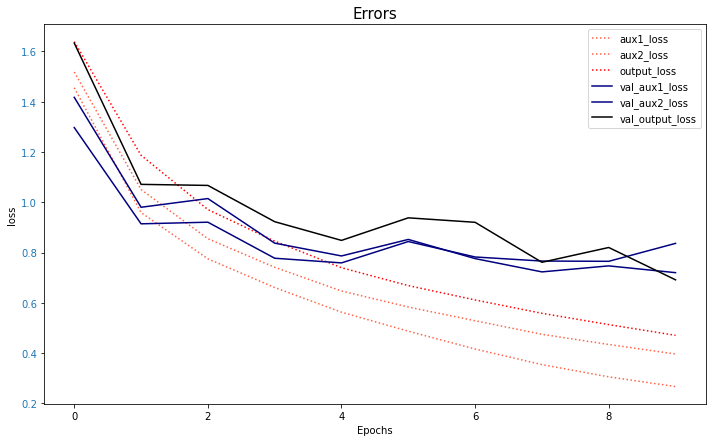

In [28]:
fig, ax1 = plt.subplots()
fig.set_size_inches((10, 6))

ax1.set_xlabel('Epochs')
ax1.set_ylabel('loss')
ax1.plot(range(EPOCHS), history.history['aux1_loss'], label='aux1_loss', linestyle=':', color='tomato')
ax1.plot(range(EPOCHS), history.history['aux2_loss'], label='aux2_loss', linestyle=':', color='tomato')
ax1.plot(range(EPOCHS), history.history['output_loss'], label='output_loss', linestyle=':', color='red')
ax1.plot(range(EPOCHS), history.history['val_aux1_loss'], label='val_aux1_loss', color='navy')
ax1.plot(range(EPOCHS), history.history['val_aux2_loss'], label='val_aux2_loss', color='navy')
ax1.plot(range(EPOCHS), history.history['val_output_loss'], label='val_output_loss', color='black')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper right')

plt.tight_layout()
plt.title('Errors', fontsize=15)
plt.show()